In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.metrics import (mean_squared_error, 
                             mean_absolute_error, 
                             r2_score, 
                             mean_absolute_percentage_error)
import warnings
warnings.filterwarnings('ignore')

In [613]:
output_path = "./dataset/out.csv"
train_path = "./dataset/train.csv"
test_path = "./dataset/test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

## EDA

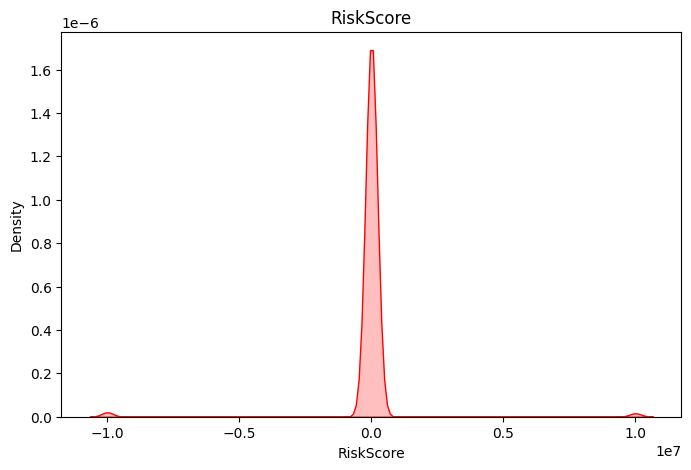

Количество числовых признаков: 29
Признаки: ['Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'LoanDuration', 'NumberOfDependents', 'MonthlyDebtPayments', 'CreditCardUtilizationRate', 'NumberOfOpenCreditLines', 'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'BankruptcyHistory', 'PreviousLoanDefaults', 'PaymentHistory', 'LengthOfCreditHistory', 'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities', 'MonthlyIncome', 'UtilityBillsPaymentHistory', 'JobTenure', 'Experience', 'NetWorth', 'BaseInterestRate', 'InterestRate', 'MonthlyLoanPayment', 'TotalDebtToIncomeRatio', 'RiskScore']
Топ положительных корреляций с RiskScore:
PaymentHistory               0.019144
TotalDebtToIncomeRatio       0.013879
MonthlyLoanPayment           0.012366
LoanAmount                   0.011771
NumberOfCreditInquiries      0.011055
NetWorth                     0.008804
TotalAssets                  0.008092
SavingsAccountBalance        0.007611
CreditCardUtilizationRate    0.0055

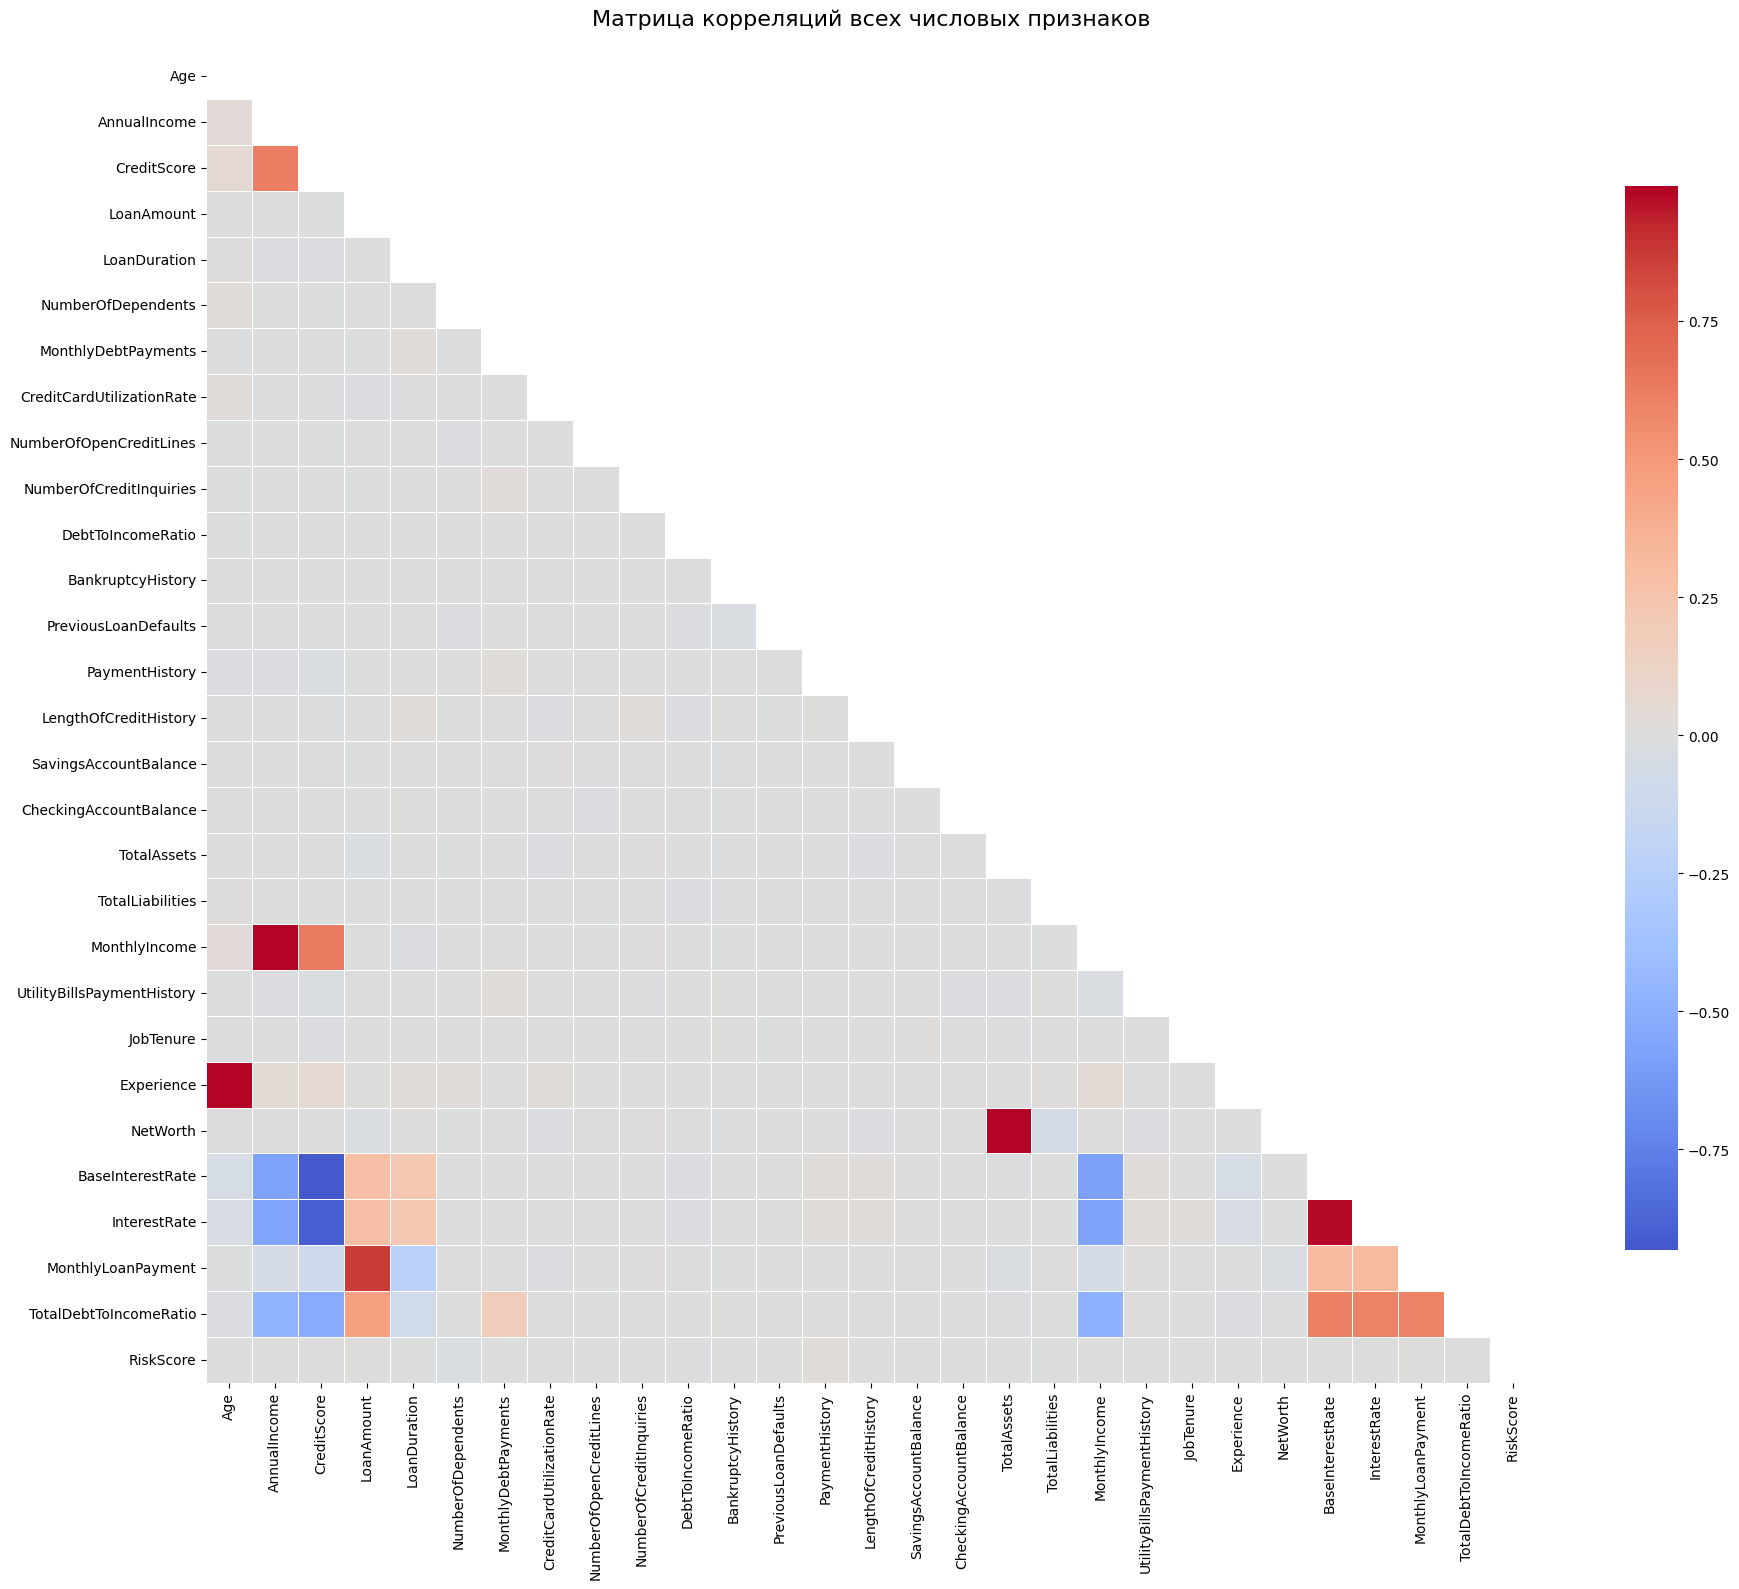

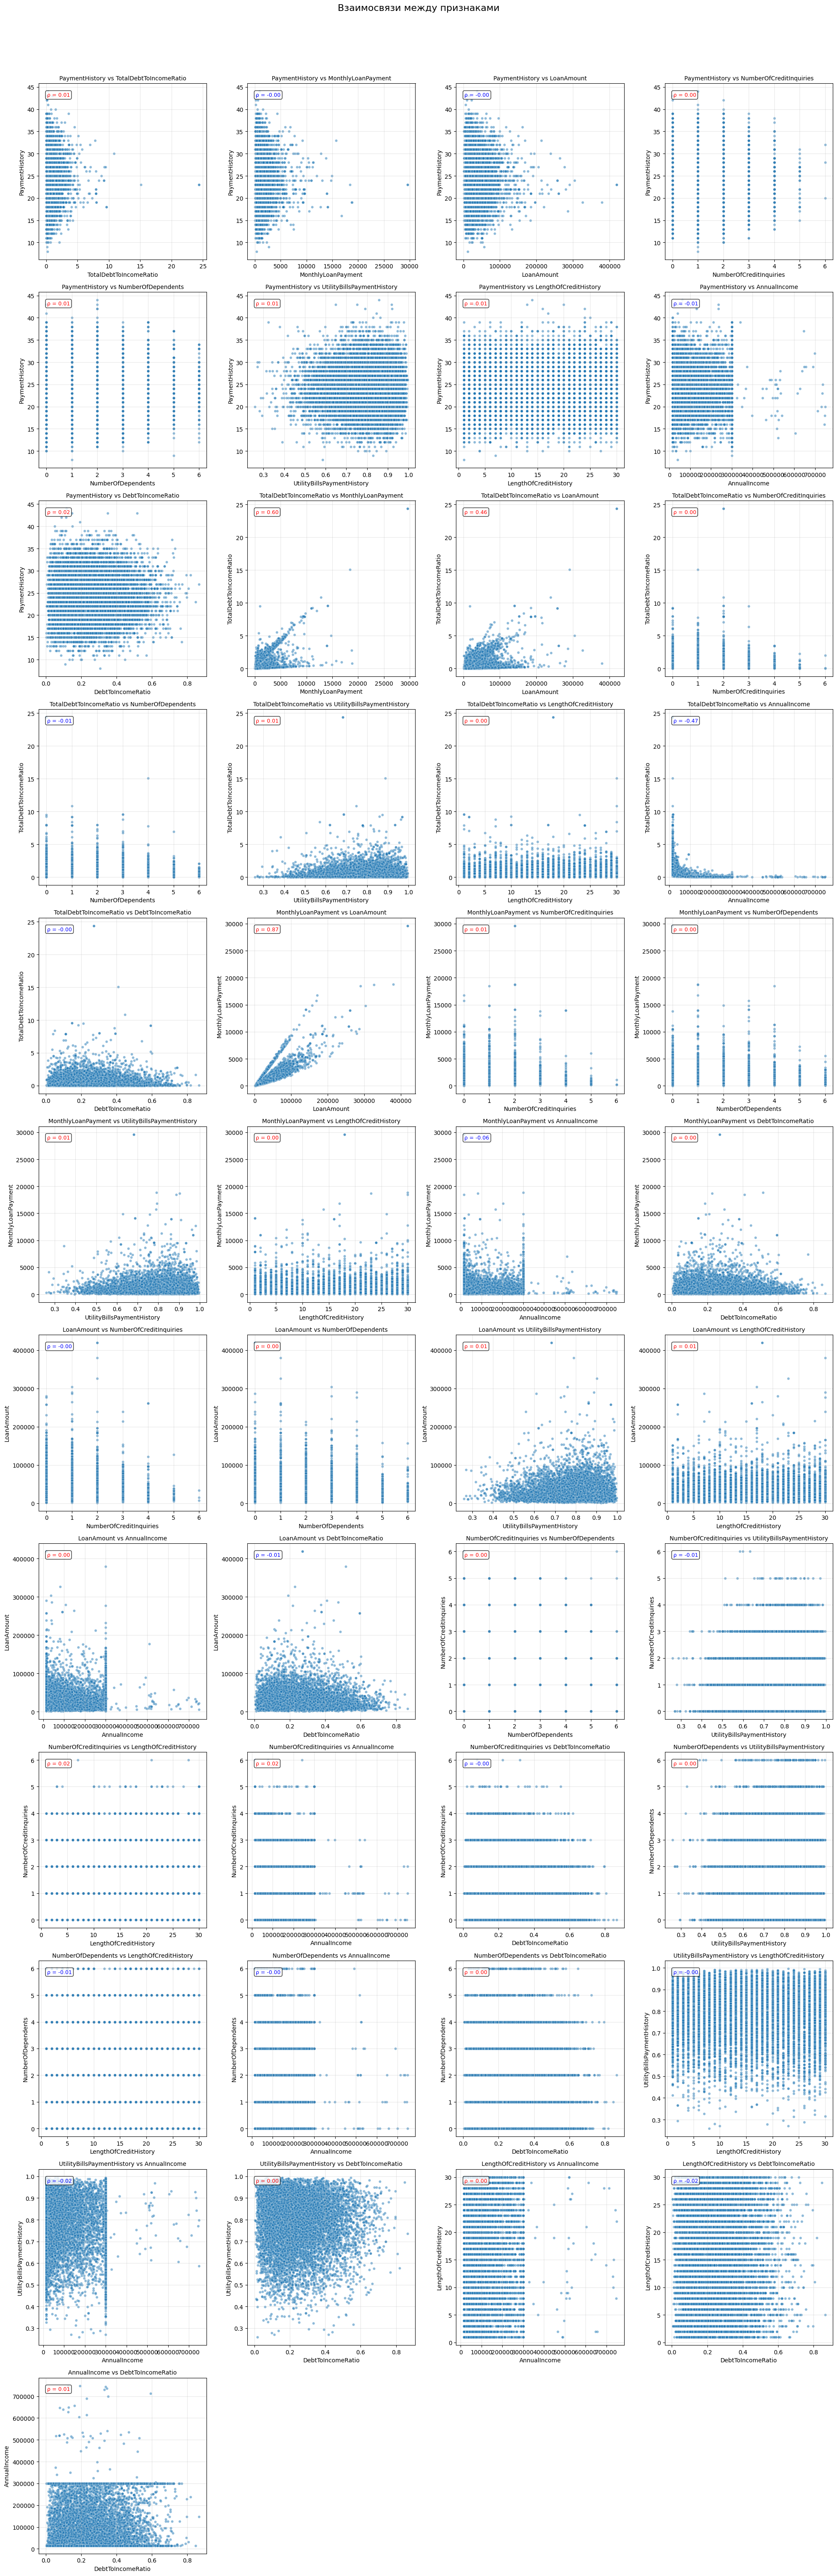

In [614]:
plt.figure(figsize=(8, 5))
sns.kdeplot(train_df['RiskScore'], fill=True, color='red')
plt.title('RiskScore')
plt.show()

numeric_cols = train_df.select_dtypes(include=[np.number]).columns

print(f"Количество числовых признаков: {len(numeric_cols)}")
print(f"Признаки: {list(numeric_cols)}")
corr_matrix = train_df[numeric_cols].corr()
print("Топ положительных корреляций с RiskScore:")
print(corr_matrix['RiskScore'].sort_values(ascending=False).head(11)[1:])
print("Топ отрицательных корреляций с RiskScore:")
print(corr_matrix['RiskScore'].sort_values(ascending=True).head(10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', 
            center=0, square=True, linewidths=0.5, 
            cbar_kws={"shrink": 0.8})
plt.title('Матрица корреляций всех числовых признаков', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

features_list = [
    'PaymentHistory', 'TotalDebtToIncomeRatio', 'MonthlyLoanPayment',
    'LoanAmount', 'NumberOfCreditInquiries', 'NumberOfDependents',
    'UtilityBillsPaymentHistory', 'LengthOfCreditHistory', 'AnnualIncome',           
    'DebtToIncomeRatio',
    ]
features_data = train_df[features_list]
n_features = len(features_list)
total_plots = ((n_features - 1) * n_features) // 2
plots_per_row = 4
rows = (total_plots + plots_per_row - 1) // plots_per_row

fig, axes = plt.subplots(rows, plots_per_row, figsize=(20, 5*rows))
axes = axes.ravel()

plot_idx = 0

for i in range(n_features):
    for j in range(i + 1, n_features):
        ax = axes[plot_idx]        
        sns.scatterplot(x=features_list[j], y=features_list[i], 
                        data=features_data, alpha=0.5, s=20, ax=ax)
        
        corr = features_data[features_list[i]].corr(features_data[features_list[j]])
        color = 'red' if corr > 0 else 'blue'
        ax.text(0.05, 0.95, f'ρ = {corr:.2f}', transform=ax.transAxes,
                fontsize=9, color=color, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        ax.set_title(f'{features_list[i]} vs {features_list[j]}', fontsize=10)        
        ax.grid(True, alpha=0.3)  
        plot_idx += 1

for i in range(plot_idx, len(axes)):
    axes[i].axis('off')

plt.suptitle('Взаимосвязи между признаками', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


__Выводы по EDA:__

1. RiskScore имеет выбросы в обе стороны, нужно скорректировать в пределах [0, 1];
2. Признаки имеют очень слабую карреляцию с RiskScore, нужно логарифмировать или применять другие нелинейные преобразования. Также нужно попробовать добавить комбинации признаков;
3. Сильнох мультиколлинеарностей на построенных графиков не очень много, можно попробовать убрать для предотвращения переобучения.

## Реализация метрик

In [ ]:
EPS = 1e-8

def my_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def my_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def my_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + EPS))) * 100

def my_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - ss_res / (ss_tot + EPS)

## Реализация линейной регрессии

In [616]:
class MyLinearRegression:
    def __init__(self, method: str = 'analytical', reg: str|None = None, lambda_reg = 0.01, lr: float = 0.01, epochs: int = 1000, batch_size: int = 32, p = 2):
        self.method = method
        self.reg = reg
        self.lambda_reg = lambda_reg
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.weights: np.ndarray = np.array([])
        self.bias: int = 0
        self.p = p

    def _fit_analytical(self, X: np.ndarray, y: np.ndarray, samples: int) -> None:
        X_ext = np.hstack([np.ones((samples, 1)), X])
        if self.reg == 'l2':
            e = np.eye(X_ext.shape[1])
            e[0,0] = 0
            theta = np.linalg.pinv(X_ext.T @ X_ext + self.lambda_reg * e) @ X_ext.T @ y
        else:
            theta = np.linalg.pinv(X_ext.T @ X_ext) @ X_ext.T @ y
        self.bias = theta[0]
        self.weights = theta[1:]

    def _fit_gd(self, X: np.ndarray, y: np.ndarray, samples: int) -> None:
        for _ in range(self.epochs):
            y_pred = np.dot(X, self.weights) + self.bias
            err = y_pred - y
            dw = 2 / samples * np.dot(X.T, err)
            db = 2 / samples * np.sum(err)
            match self.reg:
                case 'l1':
                    dw += self.lambda_reg * np.sign(self.weights)
                case 'l2':
                    dw += 2 * self.lambda_reg * self.weights
                case 'elastic':
                    dw += self.lambda_reg * (0.5*np.sign(self.weights) + self.weights)
                case 'lp':
                    dw += self.lambda_reg * self.p * np.sign(self.weights) * (np.abs(self.weights)**(self.p-1))
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def _fit_sgd(self, X: np.ndarray, y: np.ndarray, samples: int) -> None:
        for _ in range(self.epochs):
            indices = np.arange(samples)
            np.random.shuffle(indices)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for i in range(0, samples, self.batch_size):
                X_batch = X_shuffled[i:i+self.batch_size]
                y_batch = y_shuffled[i:i+self.batch_size]
                
                y_pred = np.dot(X_batch, self.weights) + self.bias
                err = y_pred - y_batch
                dw = (2 / len(X_batch)) * np.dot(X_batch.T, err)
                db = (2 / len(X_batch)) * np.sum(err)
                match self.reg:
                    case 'l1':
                        dw += self.lambda_reg * np.sign(self.weights)
                    case 'l2':
                        dw += 2 * self.lambda_reg * self.weights
                    case 'elastic':
                        dw += self.lambda_reg * (0.5*np.sign(self.weights) + self.weights)
                    case 'lp':
                        dw += self.lambda_reg * self.p * np.sign(self.weights) * (np.abs(self.weights)**(self.p-1))

                self.weights -= self.lr * dw
                self.bias -= self.lr * db

    def fit(self, X, y) -> None:
        X = np.array(X)
        y = np.array(y)
        cnt_samples, cnt_features = X.shape
        self.weights = np.zeros(cnt_features)
        self.bias = 0

        match self.method:
            case 'analytical':
                self._fit_analytical(X, y, cnt_samples)
            case 'gd':
                self._fit_gd(X, y, cnt_samples)
            case 'sgd':
                self._fit_sgd(X, y, cnt_samples)
            case _:
                raise ValueError(f'Неизвестный метод: {self.method}')

    def predict(self, X) -> np.ndarray:
        return np.dot(np.array(X), self.weights) + self.bias

## Реализация пайплайна для удобных тестов моделей

In [617]:
class RegressionPipeline:
    def __init__(self, model_type='sklearn', learning_rate=0.01, 
                 num_epochs=1000, batch_size=128, 
                 scaling_method='zscore', reg=None, lambda_reg=0.01, p=2):
        self.model_type = model_type
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.scaling_method = scaling_method
        self.reg = reg
        self.lambda_reg = lambda_reg
        self.p = p
        self._initialize_transformers()
        
    def _initialize_transformers(self):
        self.numeric_imputer = None
        self.categorical_imputer = None
        self.numeric_scaler = None
        self.polynomial_expander = None
        self.categorical_encoder = None
        self.feature_selector = None
        self.regression_model = None
    
    def _apply_log_transform(self, data):
        return np.sign(data) * np.log1p(np.abs(data))
    
    def _scale_features(self, data, numeric_columns, fit_mode=True):
        if self.scaling_method == 'zscore':
            if fit_mode:
                self.numeric_mean = data[numeric_columns].mean()
                self.numeric_std = data[numeric_columns].std().replace(0, 1)
            
            scaled_data = (data[numeric_columns] - self.numeric_mean) / self.numeric_std
            
        elif self.scaling_method == 'minmax':
            if fit_mode:
                self.numeric_min = data[numeric_columns].min()
                self.numeric_max = data[numeric_columns].max()
            
            denominator = self.numeric_max - self.numeric_min + EPS
            scaled_data = (data[numeric_columns] - self.numeric_min) / denominator
        
        data = data.copy()
        data[numeric_columns] = scaled_data
        return data
    
    def _prepare_numeric_features(self, data, numeric_columns, fit_mode=True):
        data = data.copy()

        if fit_mode:
            self.numeric_imputer = data[numeric_columns].median()
        data[numeric_columns] = data[numeric_columns].fillna(self.numeric_imputer)
        data[numeric_columns] = self._apply_log_transform(data[numeric_columns])
        data = self._scale_features(data, numeric_columns, fit_mode)
        return data
    
    def _prepare_categorical_features(self, data, categorical_columns, fit_mode=True):
        data = data.copy()
        if fit_mode:
            self.categorical_imputer = data[categorical_columns].mode().iloc[0]
            self.categorical_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
            self.categorical_encoder.fit(data[categorical_columns])
        data[categorical_columns] = data[categorical_columns].fillna(self.categorical_imputer)
        
        encoded_features = self.categorical_encoder.transform(data[categorical_columns])
        encoded_columns = self.categorical_encoder.get_feature_names_out(categorical_columns)
        encoded_df = pd.DataFrame(
            encoded_features, 
            columns=encoded_columns, 
            index=data.index
        )
        return encoded_df
    
    def _create_polynomial_features(self, data, numeric_columns, fit_mode=True):
        if fit_mode:
            self.polynomial_expander = PolynomialFeatures(degree=2, include_bias=False)
            self.polynomial_expander.fit(data[numeric_columns])
        
        poly_features = self.polynomial_expander.transform(data[numeric_columns])
        poly_columns = self.polynomial_expander.get_feature_names_out(numeric_columns)
        poly_df = pd.DataFrame(poly_features, columns=poly_columns, index=data.index)
        if fit_mode:
            self.polynomial_mean = poly_df.mean()
            self.polynomial_std = poly_df.std().replace(0, 1)
        
        poly_df = (poly_df - self.polynomial_mean) / self.polynomial_std
        return poly_df
    
    def _select_features(self, features, target, fit_mode=True):    
        if fit_mode:
            if not isinstance(features, pd.DataFrame):
                features = pd.DataFrame(features)
            
            if isinstance(target, pd.Series):
                y_series = target
            else:
                y_series = pd.Series(target)
            
            correlations = features.apply(lambda col: col.corr(y_series))
            abs_correlations = correlations.abs()
            sorted_correlations = abs_correlations.sort_values(ascending=False)
            n_features = len(features.columns)
            n_select = max(1, int(0.30 * n_features)) # 30%
            self.top_features_ = sorted_correlations.head(n_select).index.tolist()
            self.all_correlations_ = sorted_correlations

        selected_features = features[self.top_features_]
        
        return selected_features.values
    
    
    def fit(self, X, y, numeric_columns, categorical_columns):
        X = X.copy()
        X_numeric_prepared = self._prepare_numeric_features(X, numeric_columns, fit_mode=True)
        poly_features = self._create_polynomial_features(X_numeric_prepared, numeric_columns, fit_mode=True)
        cat_features = self._prepare_categorical_features(X, categorical_columns, fit_mode=True)
        all_features = pd.concat([poly_features, cat_features], axis=1)
        selected_features = self._select_features(all_features, y, fit_mode=True)

        if self.model_type == 'sklearn':
            self.regression_model = LinearRegression()
        else:
            self.regression_model = MyLinearRegression(
                method=self.model_type,
                lr=self.learning_rate,
                epochs=self.num_epochs,
                batch_size=self.batch_size,
                reg=self.reg, lambda_reg=self.lambda_reg,
                p=self.p
            )
        self.regression_model.fit(selected_features, y)
        return self
    
    def transform(self, X, numeric_columns, categorical_columns):
        X = X.copy()
        X_numeric_prepared = self._prepare_numeric_features(X, numeric_columns, fit_mode=False)
        poly_features = self._create_polynomial_features(X_numeric_prepared, numeric_columns, fit_mode=False)
        cat_features = self._prepare_categorical_features(X, categorical_columns, fit_mode=False)
        all_features = pd.concat([poly_features, cat_features], axis=1)
        selected_features = self._select_features(all_features, None, fit_mode=False)
        return selected_features
    
    def predict(self, X, numeric_columns, categorical_columns):
        processed_features = self.transform(X, numeric_columns, categorical_columns)
        predictions = self.regression_model.predict(processed_features)
        return predictions

## Реализация кросс-валидаторов

In [618]:
class MyKFold:
    def __init__(self, cnt_splits = 5, shuffle = True, random_state = 42):
        self.cnt_splits = cnt_splits
        self.shuffle = shuffle
        self.random_state = random_state

    def split(self, X):
        n = len(X)
        idxs = np.arange(n)
        if self.shuffle:
            rng = np.random.RandomState(self.random_state)
            rng.shuffle(idxs)
        
        fold_sizes = np.full(self.cnt_splits, n // self.cnt_splits, dtype=int)
        rem = n % self.cnt_splits
        if rem > 0:
            fold_sizes[:rem] += 1
        
        current = 0
        for fold_size in fold_sizes:
            start, stop = current, current + fold_size  
            test_idx = idxs[start:stop]
            train_idx = np.concatenate([idxs[:start], idxs[stop:]])
            yield train_idx, test_idx
            current = stop


class MyLOO:
    def __init__(self, shuffle = True, random_state = 42):
        self.shuffle = shuffle
        self.random_state = random_state

    def split(self, X):
        n = len(X)
        idxs = np.arange(n)
        if self.shuffle:
            rng = np.random.RandomState(self.random_state)
            rng.shuffle(idxs)
        
        for i in range(n):
            test_idx = [idxs[i]]
            train_idx = np.delete(idxs, i)
            yield train_idx, test_idx


## Основная функция преобразования и создания новых признаков

In [619]:
def change_features(df: pd.DataFrame):
    df.drop(columns=['ApplicationDate'], inplace=True)
    mapping = {'High School': 1, 'Associate': 2, 'Bachelor': 3, 'Master': 4, 'Doctorate': 5}
    df['EducationLevel'] = df['EducationLevel'].map(mapping).fillna(0).astype(float)
    df['Income'] = 1 / (np.log1p((df['MonthlyIncome'] + df['AnnualIncome'] / 12) / 2) + 1)
    df['InterestRate2'] = (df['BaseInterestRate'] + df['InterestRate']) / 2
    df["InterestRateSpread"] = df["InterestRate"] - df["BaseInterestRate"]
    df["AgeExperience"] = df["Age"] - df["Experience"] 
    df["NetIncome"] = df["NetWorth"] / (df["AnnualIncome"] + 1)
    df['NetWorth']= np.log1p(df['NetWorth']) ** 3
    df["LoanIncome"] = df["LoanAmount"] / (df["AnnualIncome"] + 1)
    df["HistToAge"] = df["LengthOfCreditHistory"] / (df["Age"] + 1)
    total = df["MonthlyLoanPayment"] + df["MonthlyDebtPayments"]
    df["DebtToIncomeRatio2"] = total / (df["MonthlyIncome"] + 1)
    df["RemainingIncome"] = df["MonthlyIncome"] - total
    df["AssetsLiabilities"] = df["TotalAssets"] / (df["TotalLiabilities"] + 1)
    df["LiabilityAssets"] = df["TotalLiabilities"] - df["TotalAssets"]
    df["NetLiabilities"] = df["NetWorth"] / (df["TotalLiabilities"] + 1)
    df["IncomeDependents"] = df["AnnualIncome"] / (df["NumberOfDependents"] + 1)
    df["ExpAge"] = df["Experience"] / (df["Age"] + 1)
    df['AnnualIncome'] = -np.log1p(df['AnnualIncome'])
    df['BaseInterestRate'] = np.log1p(df['BaseInterestRate'])
    df['LoanAmount'] = -np.log1p(df['LoanAmount'])
    scores = [300, 500, 600, 650, 700, 750, 800, 850, 900]
    names = []
    for i in range(len(scores) - 1):
        l, r = scores[i], scores[i + 1]
        names.append(f'{l}-{r}')
    df[f'BinsCreditScore'] = (pd.cut(df['CreditScore'], bins=scores, labels=names, include_lowest=True).astype(str))


## Итоговые тесты и предикт для test.csv (main)

In [620]:
train_df = train_df.dropna(subset=['RiskScore'])
train_df = train_df[train_df['RiskScore'].abs() <= 200].reset_index(drop=True)
train_df['RiskScore'] = train_df['RiskScore'].clip(0.0, 100.0)

change_features(train_df)
change_features(test_df)

X = train_df.drop(columns=['RiskScore'])
y = train_df['RiskScore']
X_test = test_df.drop(columns=['ID'])

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = list(set(X.columns) - set(numeric_cols))

methods = [
    ['sklearn', None, None, 0], 
    ['analytical', None, None, 0], 
    ['analytical', 'l2', 100, 0],
    ['gd', None, None, 0],
    ['gd', 'l1', 0.1, 0],
    ['gd', 'l2', 0.001, 0],
    ['gd', 'lp', 0.1, 3],
    ['sgd', None, None, 0],
]

print('='*20)
print('Cross-validation:')
print('='*20)

mse_results = {}
kf = MyKFold()
for method, reg, reg_lambda, p in methods:
    mse_scores = []
    for train_idx, val_idx in kf.split(X):
        X_train = X.iloc[train_idx].copy()
        X_val = X.iloc[val_idx].copy()
        y_train = y.iloc[train_idx]
        y_val = y.iloc[val_idx]

        pipe = RegressionPipeline(model_type=method, reg=reg, lambda_reg=reg_lambda, p=p)
        pipe.fit(X_train, y_train, numeric_cols, categorical_cols)
        pred_val = pipe.predict(X_val, numeric_cols, categorical_cols)
        mse = my_mse(y_val, pred_val)
        mse_scores.append(mse)
    
    mse = np.mean(mse_scores)
    mse_results[method] = mse
    reg = reg if reg else ''
    reg_lambda = reg_lambda if reg_lambda else ''
    p = p if p else ''
    print(f'  {method}({reg},{reg_lambda},{p}): mse = {mse:.3f}')

print('='*20)
print('Тест minmax:')
print('='*20)
pipe = RegressionPipeline(model_type='analytical', scaling_method='minmax')
pipe.fit(X_train, y_train, numeric_cols, categorical_cols)
pred_val_minmax = pipe.predict(X_val, numeric_cols, categorical_cols)
print('  MSE при minmax:', my_mse(y_val, pred_val_minmax))

pipe = RegressionPipeline(model_type='analytical')
pipe.fit(X, y, numeric_cols, categorical_cols)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
pipe.fit(X_train, y_train, numeric_cols, categorical_cols)
pred_val = pipe.predict(X_val, numeric_cols, categorical_cols)
print('='*20)
print('Сравнение реализованных метрик с sklearn:')
print('='*20)
print(f'  MSE: собственный - {my_mse(y_val, pred_val)}, sklearn - {mean_squared_error(y_val, pred_val)}')
print(f'  MAE: собственный - {my_mae(y_val, pred_val)}, sklearn - {mean_absolute_error(y_val, pred_val)}')
print(f'  MAPE: собственный - {my_mape(y_val, pred_val)}, sklearn - {mean_absolute_percentage_error(y_val, pred_val)*100}')
print(f'  R2: собственный - {my_r2(y_val, pred_val)}, sklearn - {r2_score(y_val, pred_val)}')

predictions = pipe.predict(X_test, numeric_cols, categorical_cols)
predictions = np.clip(predictions, 0.0, 100.0)

submission = pd.DataFrame({
    'ID': pd.Series(np.arange(len(test_df)), name='ID'),
    'RiskScore': predictions
})

submission.to_csv(output_path, index=False)

Cross-validation:
  sklearn(,,): mse = 25.151
  analytical(,,): mse = 25.151
  analytical(l2,100,): mse = 26.716
  gd(,,): mse = 30.111
  gd(l1,0.1,): mse = 30.757
  gd(l2,0.001,): mse = 30.096
  gd(lp,0.1,3): mse = 30.932
  sgd(,,): mse = 27.356
Тест minmax:
  MSE при minmax: 38.8552559606417
Сравнение реализованных метрик с sklearn:
  MSE: собственный - 25.598933786367915, sklearn - 25.598933786367915
  MAE: собственный - 3.6819466948554336, sklearn - 3.6819466948554336
  MAPE: собственный - 8.635560988971884, sklearn - 8.635560991259087
  R2: собственный - 0.914400092541452, sklearn - 0.9144000925414506


__Выводы:__

Удалось достигнуть приемлемых результатов на test.csv (MSE ~= 23.5). Основная сложность заключалась в подборе новых параметров и преобразовании исходных. Лучше всего помогло составление полиномов, логарифмизация, объединение признаков и отбор лучших корреляций с RiskScore. Для категориальных признаков хорошо помог OHE.